### Úkol

Zadání tohoto úkolu prověřuje vaše pochopení látky probírané na cvičení. Jeho cílem je implementace __výpočtu nejkratší vzdálenosti mezi obdélníky__ na snímku, který jste si **pořídili na cvičení**. 
:warning: Pokud jste nebyli na cvičení, kde se snímky potřebné k úkolu pořizovaly, napište email některému z cvičících.

Úkol má první __základní část s nápovědami__ a druhou __dobrovolnou část__ s bonusovými rozšířeními. Maximální počet bodů za __základní část je 5__, z bonusové části je možné získat až __2 prémiové__. Podrobnosti o bonusech jsou na konci notebooku. Pokud si s něčím nebudete dlouho vědět rady, napište email a domluvíme konzultaci.


Nyní uvažujme pouze základní variantu. Na začátek si je důležité uvědomit, že se __nejedná o vzdálenost mezi středy obdélníků__, nýbrž o nejkratší možné vzdálenosti hran objektů viz. [obrázek](images/patterns_lengths_example.JPG). Nezoufejte nyní, pokud nevíte jak vzdálenosti vypočítat, nápovědy v notebooku vám pomohou s řešením. Nemusíte se však striktně držet postupu, jakákoliv __individualita je vítaná__. K funkčnímu řešení se dá dobrat různými způsoby.

![](images/patterns_lengths_example.jpg)


Možná se ptáte, k čemu je to vlastně dobré. Motivace je ale jednoduchá - jedná se totiž o celkem běžně řešený problém v praxi. Navíc, v knihovně OpenCV pro to __neexistuje nativní implementace__, takže pokud zůstanete v oboru, může se vám to v budoucnu hodit. Představte si nyní, že vytváříte aplikaci, která má za úkol automatizovaně hrát hru ve které je nutné předcházet kolizím objektů ve scéně. Objekty umíte lokalizovat a ohraničit (nejčastěji obdélníkem), a mohou být různě velké a natočené. Jak nyní zjistit, jak jsou od sebe objekty daleko? V případě, že nebudou objekty (tedy ani obdélníky) natočené, lze vzdálenost vypočíst se znalostí středoškolské geometrie. V reálných situacích se tohle ale moc často nestává. Objekty jsou většinou libovolně natočené a tím se řešení trochu komplikuje. Stále si ale vystačíme se znalostí analytické geometrie ze střední školy, jen bude potřeba trochu programování navíc. Mimo kolize ve hře si můžeme představit využití i např. v aplikaci pro sledování pohybujících se objektů nebo monitorování průmyslových procesů (výrobní linka, spojování materiálů, atd.). 

Abychom si zbytečně nekomplikovali život, budeme řešení implementovat pouze na jednoduchém statickém snímku s několika obdélníky. __Zdrojový snímek základní verze__ je ten, kde jsou pouze obdélníky. Využijeme naší znalost ze cvičení a budou nás __zajímat nejkratší vzdálenosti v centimetrech__, nikoliv v pixelech.
![](images/patterns_thumb.jpg)

Předpokladem tohoto úkolu je, že __máte vypracovaný notebook ze cvičení Základy segmentace__. Budeme totiž znovu potřebovat segmentované kontury všech objektů, a vzhledem k tomu, že už máme nějakou práci hotovou, byla by škoda na ni nenavázat. Využijeme tedy vypracovaný notebook ze cvičení, upravíme pouze barevné intervaly ve funkcích `inRange()` (nově `segmentation_two_thresholds()` z __improutils__) tak, aby dávaly smysl pro nový zdrojový obrázek. 

### Import knihoven a konfigurace

In [434]:
import cv2
import numpy as np
import math

from improutils import *

### Základy segmentace (v kostce)
Postup je upravená a zrychlená verze cvičení __Základy segmentace__ s využitím funkcí z knihovny `improutils`.

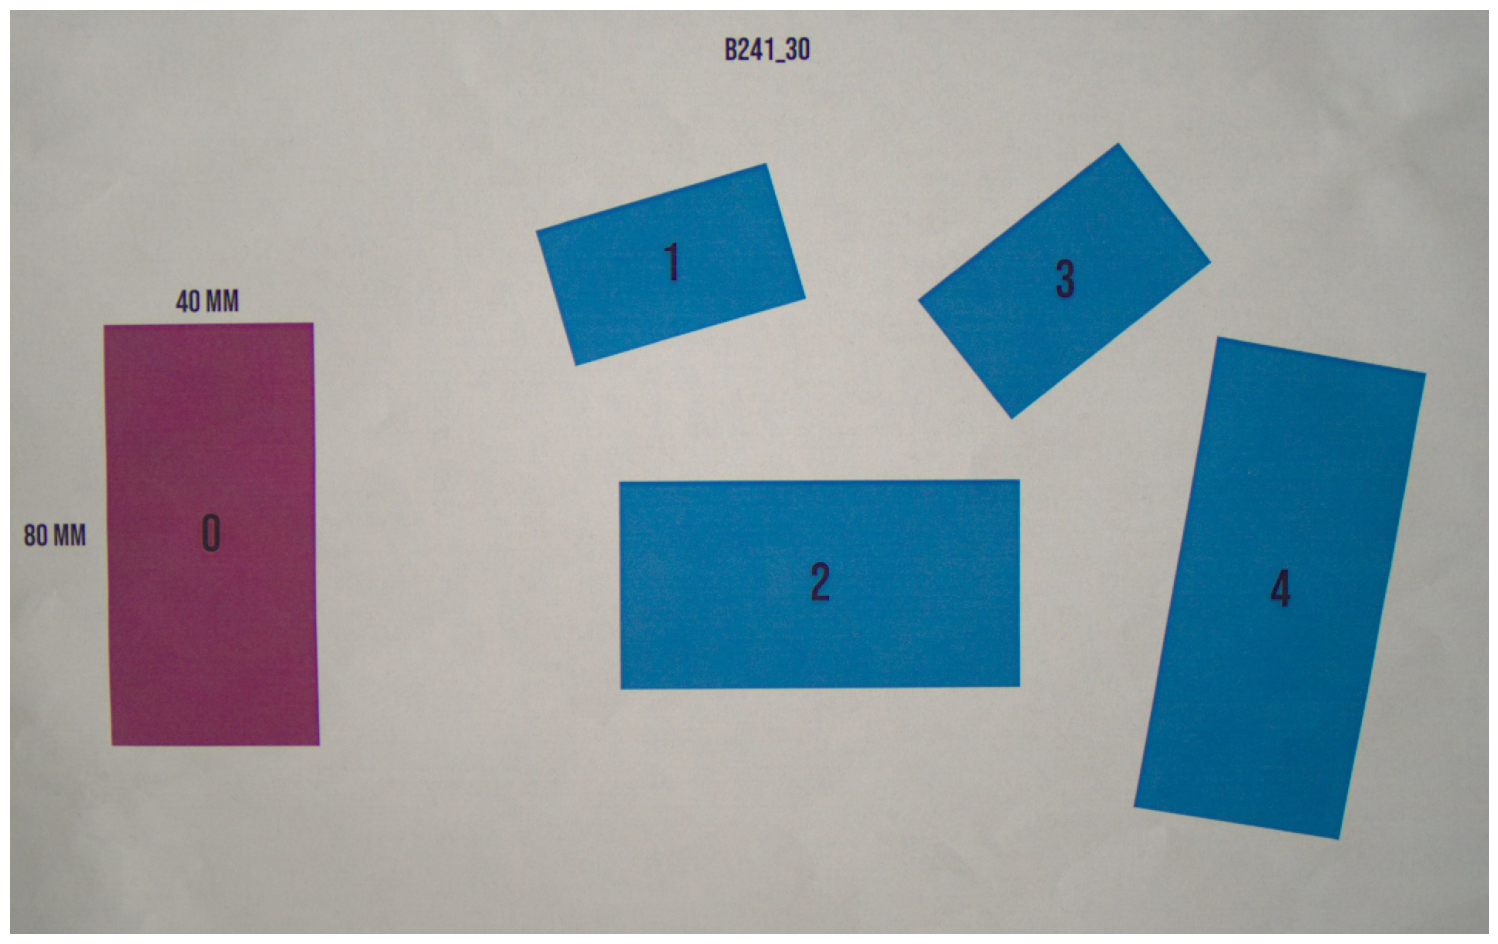

In [435]:
# načtení obrazu
img = load_image("images/img.jpg") ###
plot_images(img)

In [436]:
# segmentace obdélníků
img_hsv = to_hsv(img)
rect_others = segmentation_two_thresholds(img_hsv, (to_intensity(138), 170, 102), (to_intensity(252), 255, 190)) ### prahy pro segmentaci v RGB
rect_ref = segmentation_two_thresholds(img_hsv, (to_intensity(283), 102, 100), (to_intensity(360), 179, 232)) ### prahy pro segmentaci v RGB
rect_mask = cv2.add(rect_others, rect_ref)

# nalezení referenčního obdélníku podle velikosti kontury
drawn_ref, _, ref_cnt = find_contours(rect_mask, 140000, 150000)

# nalezení kontur všech obdélníků
###
contours_img, _, contours = find_contours(rect_mask)

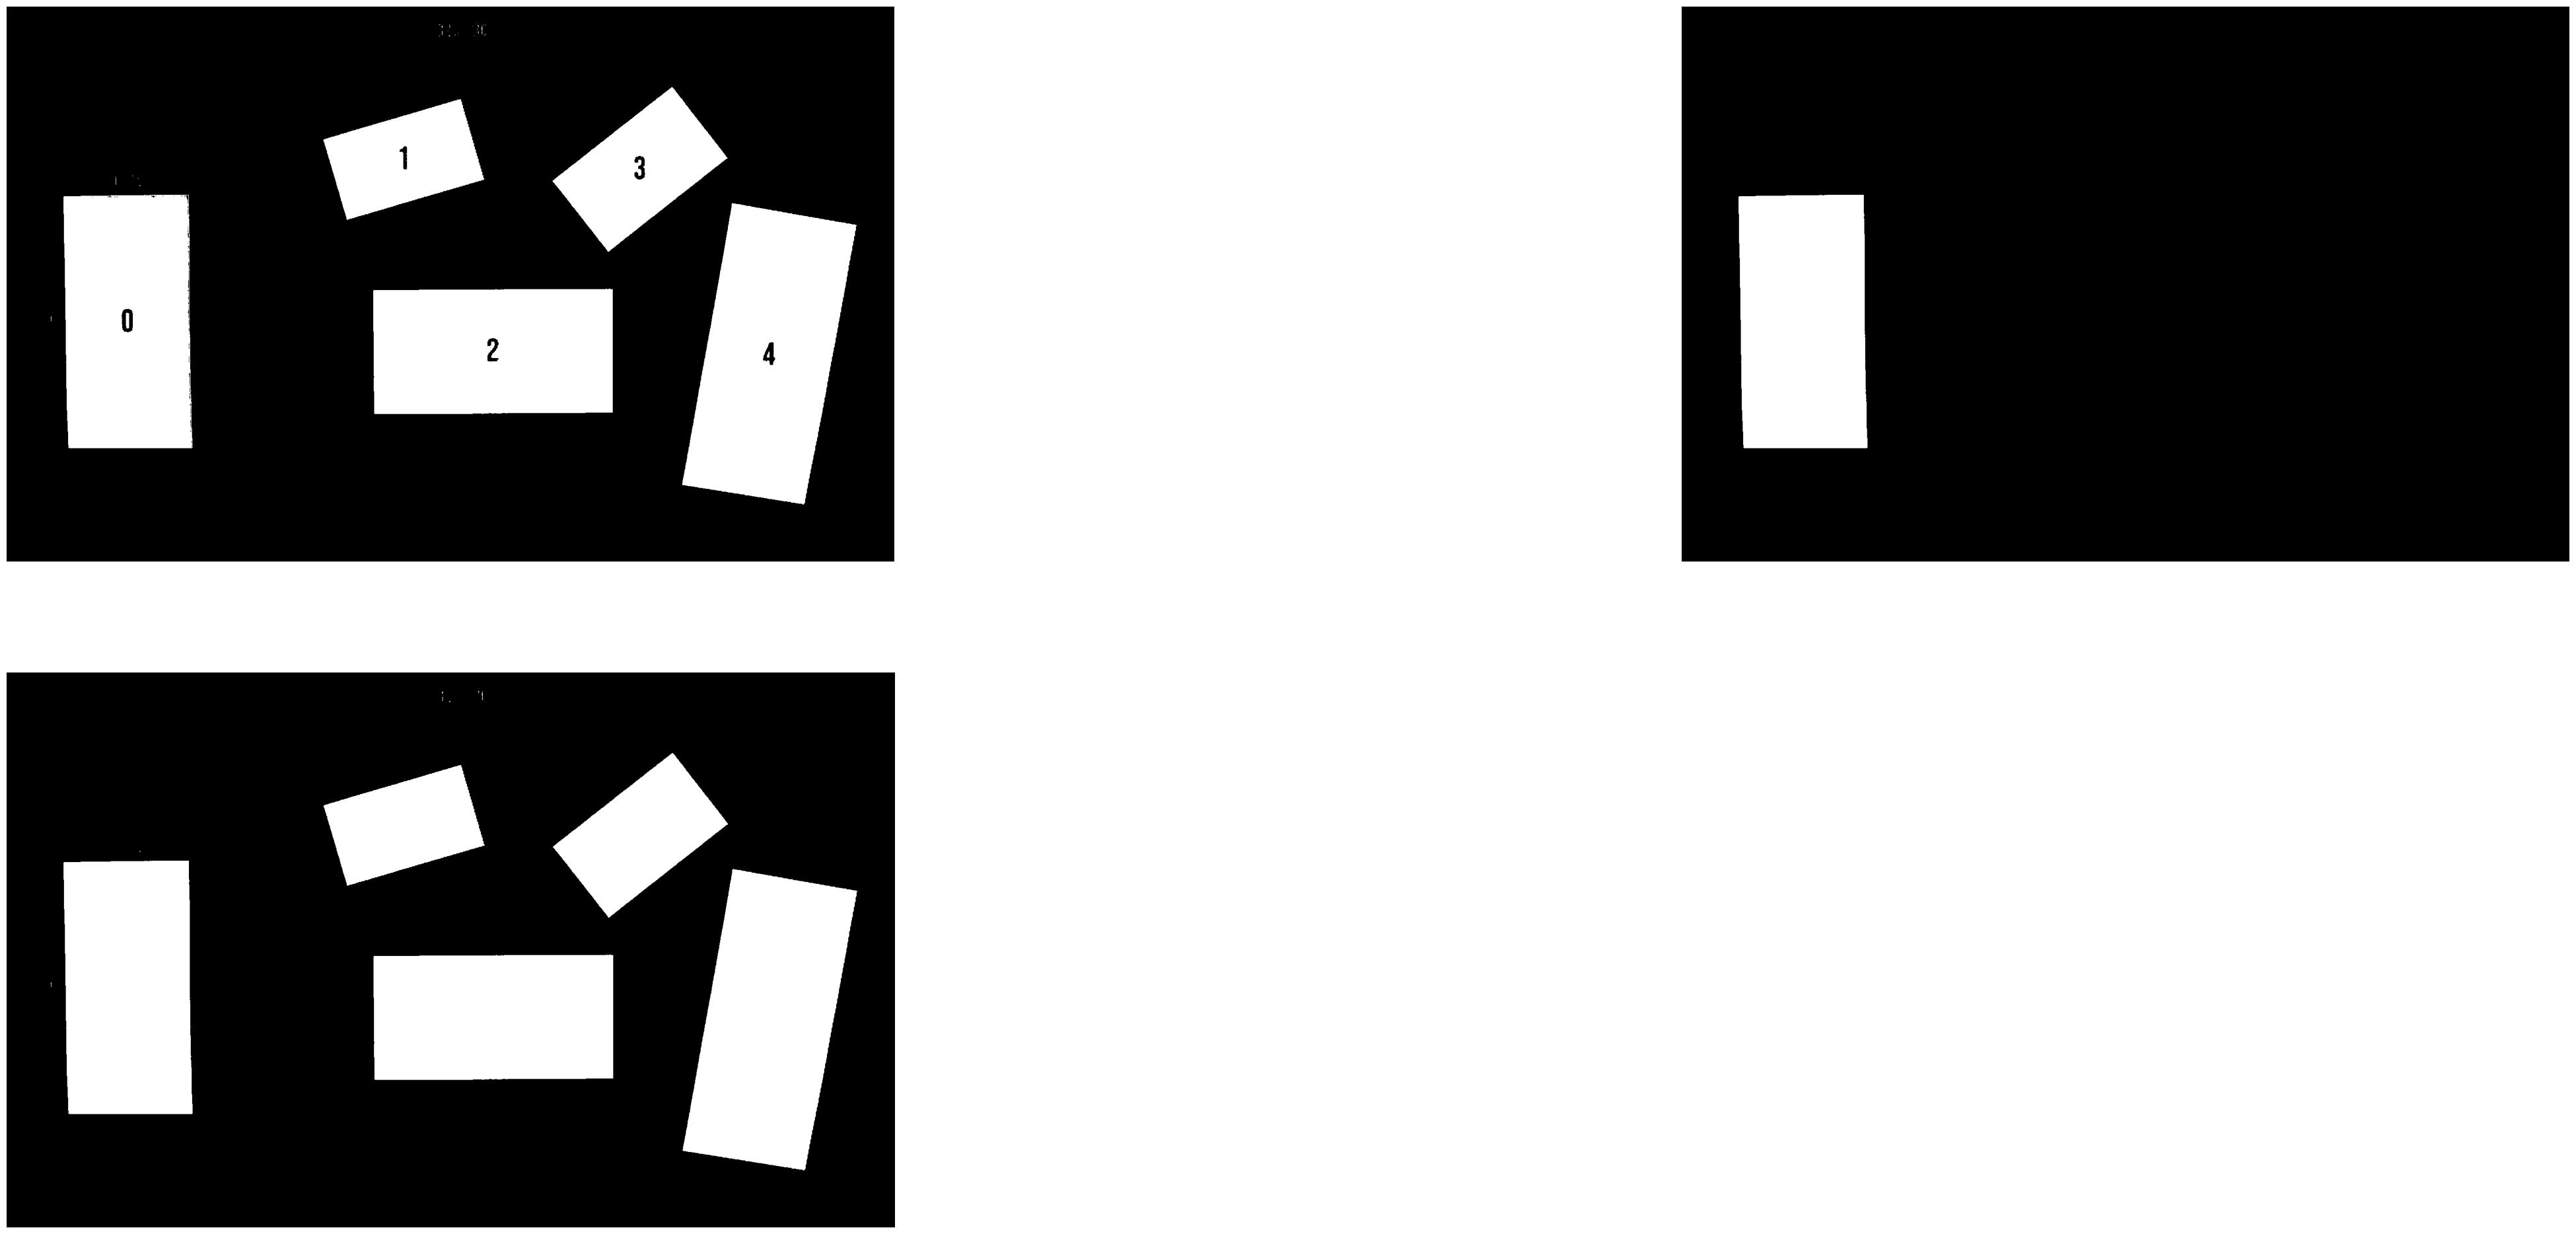

In [437]:
# zobrazení pro kontrolu
plot_images(rect_mask, drawn_ref, contours_img)

In [438]:
# vypočtení poměru mm/pix
ref_width_real = 4
ref_height_real = 8

rect = cv2.minAreaRect(ref_cnt[0])
ref_width_image, ref_height_image = rect[1]
real_image_ratio = min(ref_width_real, ref_height_real) / min(ref_width_image, ref_height_image)
print(f'Ratio between real width and image width: {real_image_ratio}')

Ratio between real width and image width: 0.01474066961453068


### Základní část

In [439]:
import itertools
import math
import cv2

V řešení ze cvičení už máme hotové segmentace referenčního i ostatních objektů uložené formou kontur. 
Všechny tyto kontury se vyplatí přemístit do jedné struktury, neboť se s ní následně bude lépe pracovat, a seřadit dle čísel, tzn. zleva do prava dle středu obdélníku.

__1) Přesuňte všechny kontury do jedné struktury (např. list).__

In [440]:
threshold = 20000
contours =  [c for c in contours if cv2.contourArea(c) > threshold]

__2) seřaďte kontury tak, aby řazení odpovídalo ID jednotlivých obdélníků, tzn. zleva doprava dle středu kontury (obdélníků), v případě rovnosti pozice středu zhora dolů__

In [441]:
rect_centers = []
for c in contours:
    r = cv2.minAreaRect(c)
    points = np.array(cv2.boxPoints(r).tolist())
    print(f"Points of the reactangle: {points}")
    print(f"x axes: {points[:,0]}")
    print(f"y axes: {points[:,1]}")
    center_x = np.mean(points[:,0])
    center_y = np.mean(points[:,1])
    print(f"The rectangle center is: {(center_x, center_y)}")
    rect_centers.append((center_x, center_y))
    print()

sorted_contours = [c for _, c in sorted(zip(rect_centers, contours), key=lambda item: (item[0][0], item[0][1]))]

Points of the reactangle: [[     792.62      612.11]
 [       1310      609.94]
 [     1311.1      878.82]
 [     793.75      880.99]]
x axes: [     792.62        1310      1311.1      793.75]
y axes: [     612.11      609.94      878.82      880.99]
The rectangle center is: (np.float64(1051.872299194336), np.float64(745.4649658203125))

Points of the reactangle: [[     1460.3      1033.7]
 [     1568.6      423.61]
 [     1838.3      471.49]
 [     1729.9      1081.6]]
x axes: [     1460.3      1568.6      1838.3      1729.9]
y axes: [     1033.7      423.61      471.49      1081.6]
The rectangle center is: (np.float64(1649.2696533203125), np.float64(752.6132736206055))

Points of the reactangle: [[     122.49       409.4]
 [     393.82      405.69]
 [     401.33      953.98]
 [        130       957.7]]
x axes: [     122.49      393.82      401.33         130]
y axes: [      409.4      405.69      953.98       957.7]
The rectangle center is: (np.float64(261.9068012237549), np.float64(

__3) Pomocí funkce `len()` ověřte, že jich máte správný počet.__

In [442]:
len(sorted_contours)

5

__4) Uložte si hodnoty všech možných indexů předchozího listu do nového listu. Může se vám k tomu hodit funkce `range()` + `list()`. Ideálně využijte i předchozí informaci o počtu kontur.__

In [443]:
indexes = list(range(len(sorted_contours)))
indexes

[0, 1, 2, 3, 4]

__5) Využijte funkci `itertools.combinations()` k získání všech možných dvojic kombinací indexů kontur. Pro jistotu si je vypiště.__

In [444]:
c_ind_comb = list(itertools.combinations(indexes , 2))
c_ind_comb

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 3),
 (2, 4),
 (3, 4)]

Nyní už to konečně začne být trochu zajímavé. Zbývá __projít všechny možné kombinace kontur, aproximovat je obdélníkem
vypočítat vzdálenost mezi všemi obdélníky, a výsledek vhodně vizualizovat v reálných jednotkách__. 
To je na jednu Jupyter buňku až moc operací, lepší řešení tedy bude tyto kroky rozpadnout do několika funkcí.

Způsobů výpočtu nejkratší vzdáleností mezi obdelníky je více. Můžete samozřejmě využít jakékoliv řešení budete chtít (za předpokladu korektnosti výsledků). V tomto postupu budem však uvažovat pouze jedno a to, které se nám zdálo nejjednoduší na pochopení. 

Pro zjedodnušení celé úlohy __není nutné uvažovat žádné složité speciální případy__ - nejsme Progtest. Nemusíte tedy uvažovat, že se tvary jakkoliv překrývají. Předpokládáme, že vzdálenost je vždy > 0. S tím také souvisí pozdější detaily jako __neřešení případů bodu ležícího na úsečce, úsečky se protínají, atd__.

Začneme tedy prvním stavebním kamenem našeho algoritmu, tedy __funkcí, která vypočte vzdálenost bodu od úsečky v pixelech__. Tato funkce je jádrem celého našeho řešení, je tedy nutné si ověřit, že vrací správné hodnoty.

Pokud vůbec netušíte, jak byste takovou věc implementovali, hledejte klíčová slova `"distance between line segment and point"` a inspirujte se. Nezapomeňte však __uvést zdroj__ + případne okomentování. __Dejte si pozor, že line segment != line__, pracujeme pouze s úsečkami.

__6) Doplňte funkci pro výpočet vzdálenosti mezi úsečkou a bodem.__

In [445]:
def eukl_distance(pt1, pt2):
    """
    returs the euklidian distance between point pt1 and point pt2
    """
    return np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)

def line_segment_to_point_dist(l_pt1, l_pt2, dst_pt): 
    """
    if the perpendicular on the line segment is in the range of the points, than the min distance is the perpendicular, otherwise
    the min distance is a distance to one of the ends of the line segment. inspired with https://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment
    """
    S = np.array(l_pt2) - np.array(l_pt1)
    N = np.array((-S[1], S[0]))

    param = np.dot(np.array(dst_pt) - np.array(l_pt1), S) / np.dot(S, S)
    if 0 <= param <= 1:
        proj = np.array(l_pt1) + param * S
        return eukl_distance(proj, dst_pt)
    else:
        return np.minimum(eukl_distance(l_pt1, dst_pt), eukl_distance(l_pt2, dst_pt))

__7) Otestujte, že funkce vrací správné výsledky a dopište alespoň dva další asserty.__

In [446]:
assert line_segment_to_point_dist((1,3), (3,4), (4,4)) ==  1
assert line_segment_to_point_dist((0,0), (10,0), (5,5)) == 5
assert line_segment_to_point_dist((0,0), (10,0), (5,-5)) == 5
assert line_segment_to_point_dist((2,1), (2,6), (2,8)) == 2

Nyní potřebujeme další stavební blok, a to nejkratší vzdálenost dvou úseček. K tomu využijeme už hotovou funkci `line_segment_to_point_dist()`. Pokud vás nenapadá jak, zkuste si to nakreslit na papír.
Nezapomeňte, že __nemusíme uvažovat speciální případy__ (např. to, že se protínají). S využítím funkce `min()` je to dokonce pouze na jeden řádek kódu.

__8) Doplňte funkci pro výpočet vzdálenosti mezi dvěmi úsečkami.__

In [447]:
def line_segments_dist(l1_pt1, l1_pt2, l2_pt1, l2_pt2):
    """
    trawl through the ends of the lines and other line
    """
    return np.min([line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt1), line_segment_to_point_dist(l1_pt1, l1_pt2, l2_pt2),
                  line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt1), line_segment_to_point_dist(l2_pt1, l2_pt2, l1_pt2)])

__9) Otestujte, že funkce vrací správné výsledky a dopište alespoň dva další asserty.__

In [448]:
assert line_segments_dist((1,3), (3,4), (5,7), (5,1)) ==  2
assert line_segments_dist((1,5), (6,5), (7,7), (7,5)) == 1
assert line_segments_dist((1,3), (5,3), (6,3), (7,3)) == 1
assert line_segments_dist((1,4), (3,2), (2,5), (4,3)) == np.sqrt(2)

Když už umíme vypočítat nejkratší vzdálenost dvou úseček, máme vše potřebné pro výpočet nejkratší vzdálenosti mezi dvěma obdélníky. Stačí si jen uvědomit, že obdélník je složen ze čtyř spojených úseček. 

Typ vstupních parametrů funkce `rect_dist` je na vás. Nezapomeňte však, že `cv2.minAreaRect()` nevrací přímo souřadnice rohových bodů. Připomeňte si `cv2.boxPoints()` a `order_points()`.

__10) Doplňte funkci pro výpočet vzdálenosti mezi dvěma obdélníky.__

In [449]:
def rect_dist(r1_pts: np.ndarray, r2_pts: np.ndarray):
    """
    Supposes we get the format where [p1, p2, p3, p4] ordered clockwise
    """
    distances = []
    for _ in range(4):
        r1_pts = np.roll(r1_pts, 1, axis=0)
        for _ in range(4):
            r2_pts = np.roll(r2_pts, 1, axis=0)
            distances.append(line_segments_dist(r1_pts[0], r1_pts[1], r2_pts[0], r2_pts[1]))
    return np.min(distances)

__11) Otestujte, že funkce vrací správné výsledky a dopište alespoň dva další asserty.__

In [450]:
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((7,7), (9,7), (9, 5), (7, 5))) == 1
assert rect_dist(((1,5), (6,5), (6,3), (1,3)), ((4,10), (6, 8), (4, 6), (2,8))) == 1
assert rect_dist(((1,1), (3,1), (3,3), (1,3)), ((6,3), (6,4), (7,4), (7,3))) == 3
assert rect_dist(((1,1), (3,1), (3,3), (1,3)), ((4,4), (4,5), (5,5), (5,4))) == np.sqrt(2)

Blížíme se do finále. Úplně v první buňce tohoto úkolu bychom měli mít vytvořený list se všemi konturami a list všech dvojic kombinací indexů kontur. Kontury vhodně převeďte tak, aby je bylo možné předat do definované funkce `rect_dist()` a tím získat vzdálenost mezi dvěma obdélníky v pixelech. Následně přepočítejte pixely na skutečné jednotky a vypiště nalezené vzdálenosti ve vhodném a kontrolovatelném formátu (např.: 1 <-> 3: 2.2 cm). 

__12) Vypočítejte vzdálenosti mezi všemi obdélníky ve snímku, vypiště vzdálenosti ve vhodném formátu v centimetrech.__

In [451]:
for comb in c_ind_comb:
    #print(f"Current combination is {comb}")
    r1 = cv2.minAreaRect(sorted_contours[comb[0]])
    r2 = cv2.minAreaRect(sorted_contours[comb[1]])
    points1 = np.array(order_points(cv2.boxPoints(r1)).tolist())
    points2 = np.array(order_points(cv2.boxPoints(r2)).tolist())
    #print(f"The poins of the first rectangle are:{points1}")
    #print(f"The poins of the second rectangle are:{points2}")
    print(f"THE DISTANCE BETWEEN THE RECTANGLE {comb[0]} AND {comb[1]} IS {rect_dist(points1, points2) * real_image_ratio}cm")
    print()

THE DISTANCE BETWEEN THE RECTANGLE 0 AND 1 IS 4.599089803898212cm

THE DISTANCE BETWEEN THE RECTANGLE 0 AND 2 IS 5.79873574902799cm

THE DISTANCE BETWEEN THE RECTANGLE 0 AND 3 IS 11.589258413480861cm

THE DISTANCE BETWEEN THE RECTANGLE 0 AND 4 IS 15.653726600701798cm

THE DISTANCE BETWEEN THE RECTANGLE 1 AND 2 IS 2.368965599522641cm

THE DISTANCE BETWEEN THE RECTANGLE 1 AND 3 IS 2.154114975729218cm

THE DISTANCE BETWEEN THE RECTANGLE 1 AND 4 IS 7.896783993159667cm

THE DISTANCE BETWEEN THE RECTANGLE 2 AND 3 IS 1.1718675295143395cm

THE DISTANCE BETWEEN THE RECTANGLE 2 AND 4 IS 2.5639264744714882cm

THE DISTANCE BETWEEN THE RECTANGLE 3 AND 4 IS 1.2039366870851766cm



### Bonusová část

Pokud to pro vás byla doposuď zívačka, a chtěli byste nějaké body navíc, je možné získat až 2 prémiové body za trochu dalšího přemýšlení a programování. Za každý splněný úkol ze seznamu je __1 prémiový bod__. Maximálně je možné získat __až 2 prémiové__.

#### Úkoly:
1) Vytvořte vhodnou vizualizaci vzdáleností mezi objekty. Např. vykreslení nejkratší úsečky mezi obdélníky a vypsání její délky v centimetrech.

2) Upravte váš algoritmus tak, aby korektně fungoval i pro bonusový snímek, který obsahuje kromě obdélníků i kružnice. Tedy podpora výpočtu nejkratší vzdálenosti mezi kombinací tvarů obdélník a kružnice. Jiné elipsové tvary pro jednoduchost neuvažujte. Může se vám na to hodit `cv2.fitEllipse()`.

3) Zkuste navrhnout jiné řešení než to využívající vzdálenost bodů od úsečky. Nemusí být 100% funkční ve všech případech, ale jasně vyspecifikujte jeho úskalí a případy kdy nebude fungovat.

In [452]:
def line_segment_to_point_dist_m(l_pt1, l_pt2, dst_pt): 
    """
    Modification, so the function also returns the points of the distance    
    """
    S = np.array(l_pt2) - np.array(l_pt1)

    param = np.dot(np.array(dst_pt) - np.array(l_pt1), S) / np.dot(S, S)
    if 0 <= param <= 1:
        proj = np.array(l_pt1) + param * S
        return eukl_distance(proj, dst_pt), proj, np.array(dst_pt)
    else:
        dist1 = eukl_distance(l_pt1, dst_pt)
        dist2 = eukl_distance(l_pt2, dst_pt)
        if dist1 < dist2:
            return dist1, np.array(l_pt1), np.array(dst_pt)
        else:
            return dist2, np.array(l_pt2), np.array(dst_pt)

In [453]:
def line_segments_dist_m(l1_pt1, l1_pt2, l2_pt1, l2_pt2):
    """
    Modification, -||-
    """
    dist_min = np.min([line_segment_to_point_dist_m(l1_pt1, l1_pt2, l2_pt1)[0], line_segment_to_point_dist_m(l1_pt1, l1_pt2, l2_pt2)[0],
                  line_segment_to_point_dist_m(l2_pt1, l2_pt2, l1_pt1)[0], line_segment_to_point_dist_m(l2_pt1, l2_pt2, l1_pt2)[0]])
    if dist_min == line_segment_to_point_dist_m(l1_pt1, l1_pt2, l2_pt1)[0]:
        return line_segment_to_point_dist_m(l1_pt1, l1_pt2, l2_pt1)
    elif dist_min == line_segment_to_point_dist_m(l1_pt1, l1_pt2, l2_pt2)[0]:
        return line_segment_to_point_dist_m(l1_pt1, l1_pt2, l2_pt2)
    elif dist_min == line_segment_to_point_dist_m(l2_pt1, l2_pt2, l1_pt1)[0]:
        return line_segment_to_point_dist_m(l2_pt1, l2_pt2, l1_pt1)
    else:
        return line_segment_to_point_dist_m(l2_pt1, l2_pt2, l1_pt2)

In [454]:
def rect_dist_m(r1_pts: np.ndarray, r2_pts: np.ndarray):
    """
    Modification, -||-
    """
    min_dist = float("inf")
    closest_pt1 = None
    closest_pt2 = None
    
    for _ in range(4):
        r1_pts = np.roll(r1_pts, 1, axis=0)
        for _ in range(4):
            r2_pts = np.roll(r2_pts, 1, axis=0)
            dist, pt1, pt2 = line_segments_dist_m(r1_pts[0], r1_pts[1], r2_pts[0], r2_pts[1])
            if dist < min_dist:
                min_dist = dist
                closest_pt1 = pt1
                closest_pt2 = pt2
    return min_dist, closest_pt1, closest_pt2

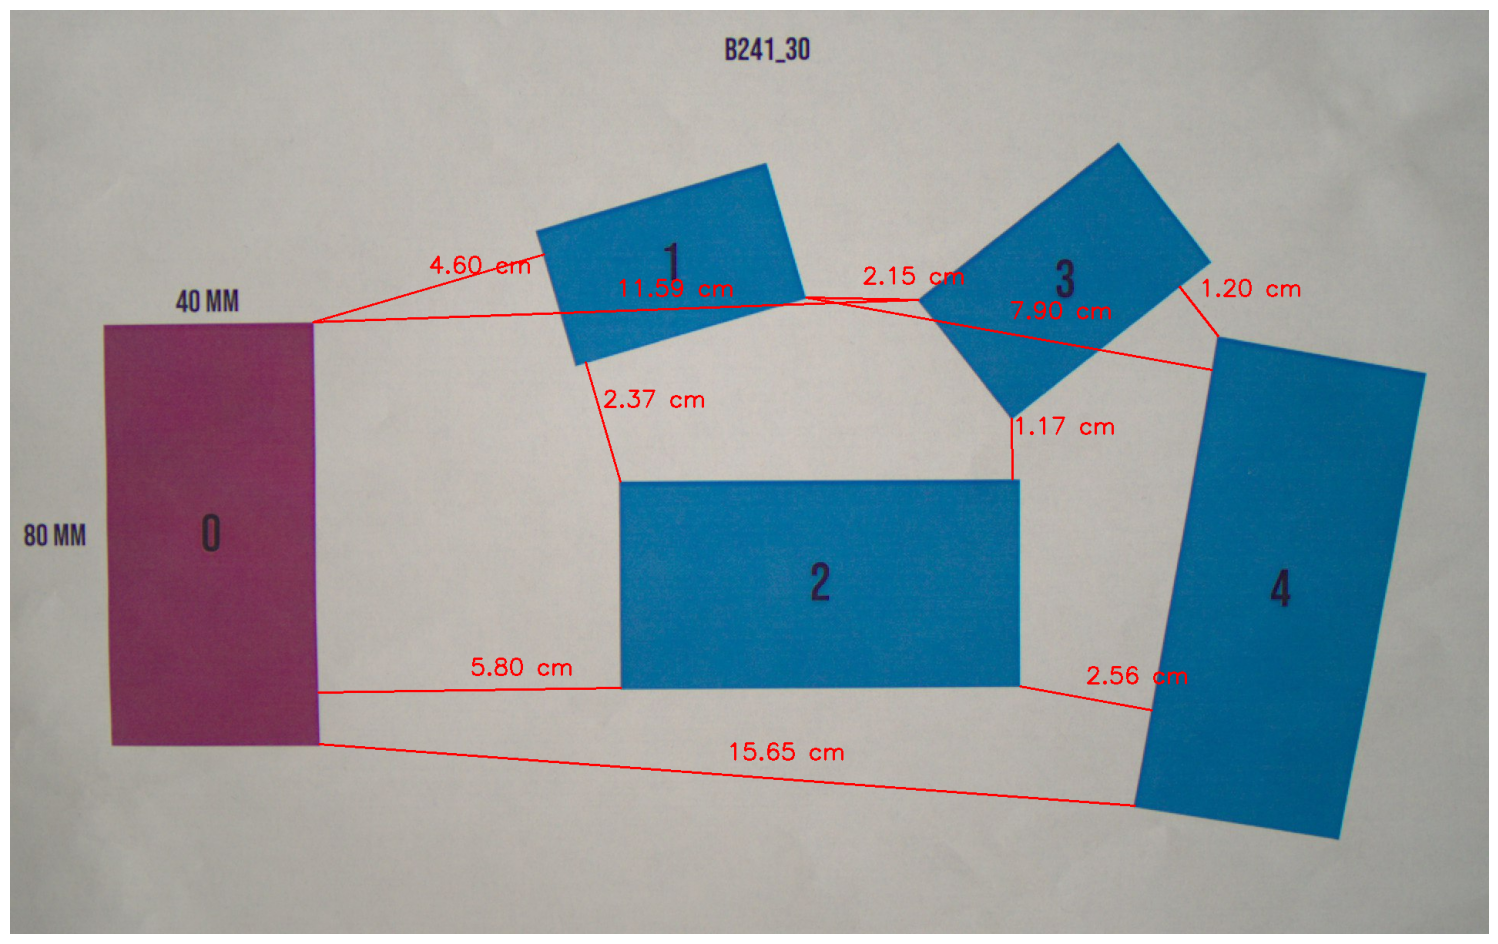

In [455]:
viz_img = img.copy()
for comb in c_ind_comb:
    r1 = cv2.minAreaRect(sorted_contours[comb[0]])
    r2 = cv2.minAreaRect(sorted_contours[comb[1]])
    points1 = np.array(order_points(cv2.boxPoints(r1)).tolist())
    points2 = np.array(order_points(cv2.boxPoints(r2)).tolist())
    dist, pt1, pt2 = rect_dist_m(points1, points2)
    cv2.line(viz_img, tuple(pt1.astype(int)), tuple(pt2.astype(int)), (0,0,255), 2)
    mid = (int((pt1[0] + pt2[0]) / 2), int((pt1[1] + pt2[1]) / 2 - 20))
    text = f"{dist * real_image_ratio:.2f} cm"
    cv2.putText(viz_img, text, mid, cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
plot_images(viz_img)